#### LIBRARIES USED

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import time
from scipy.signal import convolve2d

#### SEGREGATION MODEL

The model describes the evolution of an population in a space with two types of agents: reds and blues. A red agent is happy in it's site depending of it's neighbours; it is the same for the blues.

#### FUNCTIONS'S DEFINITIONS

In [4]:
border_value = -2.0
vacancy_value = -1.0
red_value = 0.0
blue_value = 1.0
unhappy_red_value = 2.0
unhappy_blue_value = 3.0
highlight_value = 4.0

In [5]:
def plot_grid(agents):
    # creates a discrete colormap
    border = np.array([0,0,0,0.8])                                  # black
    vacancy = np.array([147.0/255, 148.0/255, 150.0/255])           # grey
    red = np.array([255.0/255, 0.0/255, 0.0/255])             # red
    blue = np.array([0.0/255, 0.0/255, 255.0/255])          # blue
    unhappy_red = np.array([127.0/255, 0.0/255, 0.0/255])      # dark red
    unhappy_blue = np.array([0.0/255, 0.0/255, 127.0/255])    # dark blue
    highlight = np.array([247.0/255, 236.0/255, 0])           #yellow
    cmap = colors.ListedColormap([border, vacancy, red, blue, unhappy_red, unhappy_blue,highlight])
    # determines the limits of each color:
    # if the agent number x is in the range [border_value,border_value + 1), it's color is black,
    # if x is in the range [vacancy_value, vacancy_value + 1), it's color is grey,
    # and so on...
    bounds = [border_value,vacancy_value,red_value,blue_value,unhappy_red_value,unhappy_blue_value,highlight_value, highlight_value + 1]            
    norm = colors.BoundaryNorm(bounds, cmap.N)

    size = 8
    fig, ax = plt.subplots(figsize=(size,size))
    ax.imshow(agents, cmap=cmap, norm=norm)

    # draws gridlines
    #ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    #ax.set_xticks(np.arange(-0.5, agents.shape[1], 1));
    #ax.set_yticks(np.arange(-0.5, agents.shape[0], 1));

    plt.show()

In [7]:
def create_city(N, red_density, blue_density, city_type, neighbourhood_range):
    vacancy_array = np.array([[-1,-1]])
    # creates a city with borders
    if (city_type == "closed"):
        city = np.full((N+(2*neighbourhood_range),N+(2*neighbourhood_range)), border_value)
        reds = 0.0
        blues = 0.0
        for i in range(neighbourhood_range,N+neighbourhood_range):
            for j in range(neighbourhood_range,N+neighbourhood_range):
                rnd = np.random.random()
                if rnd <= red_density:
                    city[i,j] = red_value
                    reds += 1
                elif (red_density < rnd <= red_density + blue_density):
                    city[i,j] = blue_value
                    blues += 1
                else:
                    city[i,j] = vacancy_value
                    vacancy_array = np.append(vacancy_array, [[i,j]], axis=0)
    
    # creates a city without borders, that will be a toroidal grid
    elif (city_type == "open"):
        city = np.full((N,N), vacancy_value)
        reds = 0.0
        blues = 0.0
        for i in range(0,N):
            for j in range(0,N):
                rnd = np.random.random()
                if rnd <= red_density:
                    city[i,j] = red_value
                    reds += 1
                elif (red_density < rnd <= red_density + blue_density):
                    city[i,j] = blue_value
                    blues += 1
                else:
                    vacancy_array = np.append(vacancy_array, [[i,j]], axis=0)
    
    vacancy_array = np.delete(vacancy_array, 0,0)
    
    return city, vacancy_array, reds, blues

In [8]:
def detect_unhappiness(city, city_type, i, j, neighbourhood_range, tolerance):
    value = city[i,j]
    red_neighbours = 0
    blue_neighbours = 0
    fraction = 0.0

    if(city_type == "closed"):
        #check red unhappiness
        if(city[i,j] == red_value or city[i,j] == unhappy_red_value):
            red_neighbours -= 1
            for Di in range(-neighbourhood_range,neighbourhood_range+1):
                for Dj in range(-neighbourhood_range,neighbourhood_range+1):
                    if(city[(i+Di)%N,(j+Dj)%N] == red_value or city[(i+Di)%N,(j+Dj)%N] == unhappy_red_value):
                        red_neighbours += 1
                    elif(city[(i+Di)%N,(j+Dj)%N] == blue_value or city[(i+Di)%N,(j+Dj)%N] == unhappy_blue_value):
                        blue_neighbours += 1

            # red happiness condition
            # fraction is the ratio of neighbours of a different type over the total number of neighbours
            if(blue_neighbours + red_neighbours != 0):
                fraction = float(blue_neighbours)/(blue_neighbours + red_neighbours)
            
            if (tolerance <= fraction):
                value = unhappy_red_value
            else:
                value = red_value

        #check blue unhappiness
        elif(city[i,j] == blue_value or city[i,j] == unhappy_blue_value):
            blue_neighbours -= 1
            for Di in range(-neighbourhood_range,neighbourhood_range+1):
                for Dj in range(-neighbourhood_range,neighbourhood_range+1):
                    if(city[(i+Di)%N,(j+Dj)%N] == red_value or city[(i+Di)%N,(j+Dj)%N] == unhappy_red_value):
                        red_neighbours += 1
                    elif(city[(i+Di)%N,(j+Dj)%N] == blue_value or city[(i+Di)%N,(j+Dj)%N] == unhappy_blue_value):
                        blue_neighbours += 1

            # blue happiness condition
            # fraction is the ratio of neighbours of a different type over the total number of neighbours
            if(blue_neighbours + red_neighbours != 0):
                fraction = float(red_neighbours)/(blue_neighbours + red_neighbours)

            if (tolerance <= fraction):
                value = unhappy_blue_value
            else:
                value = blue_value

                
    elif(city_type == "open"):
        #check red unhappiness
        if(city[i,j] == red_value or city[i,j] == unhappy_red_value):
            red_neighbours -= 1
            for Di in range(-neighbourhood_range,neighbourhood_range+1):
                for Dj in range(-neighbourhood_range,neighbourhood_range+1):
                    if(city[(i+Di)%N,(j+Dj)%N] == red_value or city[(i+Di)%N,(j+Dj)%N] == unhappy_red_value):
                        red_neighbours += 1
                    elif(city[(i+Di)%N,(j+Dj)%N] == blue_value or city[(i+Di)%N,(j+Dj)%N] == unhappy_blue_value):
                        blue_neighbours += 1

            # red happiness condition
            # fraction is the ratio of neighbours of a different type over the total number of neighbours
            if(blue_neighbours + red_neighbours != 0):
                fraction = float(blue_neighbours)/(blue_neighbours + red_neighbours)
            
            if (tolerance <= fraction):
                value = unhappy_red_value
            else:
                value = red_value

        #check blue unhappiness
        elif(city[i,j] == blue_value or city[i,j] == unhappy_blue_value):
            blue_neighbours -= 1
            for Di in range(-neighbourhood_range,neighbourhood_range+1):
                for Dj in range(-neighbourhood_range,neighbourhood_range+1):
                    if(city[(i+Di)%N,(j+Dj)%N] == red_value or city[(i+Di)%N,(j+Dj)%N] == unhappy_red_value):
                        red_neighbours += 1
                    elif(city[(i+Di)%N,(j+Dj)%N] == blue_value or city[(i+Di)%N,(j+Dj)%N] == unhappy_blue_value):
                        blue_neighbours += 1

            # blue happiness condition
            # fraction is the ratio of neighbours of a different type over the total number of neighbours
            if(blue_neighbours + red_neighbours != 0):
                fraction = float(red_neighbours)/(blue_neighbours + red_neighbours)

            if (tolerance <= fraction):
                value = unhappy_blue_value
            else:
                value = blue_value

    return value

In [9]:
def detect_city_unhappiness(city, city_type, neighbourhood_range, tolerance):  
    if(city_type == "closed"):
        N = city.shape[0] - 2*neighbourhood_range
        unhappy_agents = np.full(((N*N)+1, 2), [-1,-1])
        unhappy_map = np.full((N,N),-1)
        count = 0

        for i in range(neighbourhood_range,N+neighbourhood_range):
            for j in range(neighbourhood_range,N+neighbourhood_range):
                value = detect_unhappiness(city, city_type, i, j, neighbourhood_range, tolerance)
                if(value == unhappy_red_value or value == unhappy_blue_value):
                    count += 1
                    city[i,j] = value
                    unhappy_agents[count] = [i,j]
                    unhappy_map[i,j] = count
                        
    elif(city_type == "open"):
        N = city.shape[0]
        unhappy_agents = np.full(((N*N)+1, 2), [-1,-1])
        unhappy_map = np.full((N,N),-1)
        count = 0

        for i in range(0,N):
            for j in range(0,N):
                value = detect_unhappiness(city, city_type, i, j, neighbourhood_range, tolerance)
                if(value == unhappy_red_value or value == unhappy_blue_value):
                    count += 1
                    city[i,j] = value
                    unhappy_agents[count] = [i,j]
                    unhappy_map[i,j] = count
    
    unhappy_agents[0] = [count, count]
    
    return city, unhappy_agents, unhappy_map

In [10]:
def add_unhappy_agent(unhappy_agents, unhappy_map, i, j):
    count = unhappy_agents[0,0]
    count += 1
    unhappy_agents[count] = [i,j]
    unhappy_map[i,j] = count
    unhappy_agents[0] = [count,count]

    return unhappy_agents, unhappy_map

In [11]:
def remove_unhappy_agent(unhappy_agents, unhappy_map, i, j):
    count = unhappy_agents[0,0]
    position = unhappy_map[i,j]
    aux_i, aux_j = unhappy_agents[count]
    unhappy_agents[position] = [aux_i, aux_j]
    unhappy_map[aux_i, aux_j] = position
    unhappy_agents[count] = [-1, -1]
    count -= 1
    unhappy_agents[0] = [count,count] 
    unhappy_map[i,j] = -1

    return unhappy_agents, unhappy_map

In [12]:
def simulation_step(city, city_type, unhappy_agents, unhappy_map, vacancy_array, neighbourhood_range, tolerance):
    if(city_type == "open"):
        N = city.shape[0] 
        n = unhappy_agents[0,0]

        rnd = np.random.randint(1,n+1)
        i, j = unhappy_agents[rnd]

        n2 = vacancy_array.shape[0]
        rnd2 = np.random.randint(0,n2)
        
        # update the vacancy_array
        new_i, new_j = vacancy_array[rnd2]
        vacancy_array[rnd2] = [i,j]
        
        # update the city, unhappy_array and unhappy_map
        a = city[i,j]
        if(a == unhappy_red_value):
            city[new_i,new_j] = red_value
        elif(a == unhappy_blue_value):
            city[new_i,new_j] = blue_value
        city[i,j] = vacancy_value
        
        count = unhappy_agents[0,0]
        aux_i, aux_j = unhappy_agents[count]
        unhappy_agents[rnd] = unhappy_agents[count]
        unhappy_map[aux_i, aux_j] = rnd
        unhappy_agents[count] = [-1,-1]
        unhappy_map[i,j] = -1
        count -= 1
        unhappy_agents[0] = [count,count]
        
        """
        # testing purposes
        for _ in range(4):
            city[i,j] = highlight_value
            city[new_i,new_j] = highlight_value
            plot_grid(city)
            time.sleep(0.1)
            display.clear_output(wait=True)
            city[i,j] = vacancy_value
            if(a == unhappy_red_value):
              city[new_i,new_j] = red_value
            elif(a == unhappy_blue_value):
              city[new_i,new_j] = blue_value
            plot_grid(city)
            time.sleep(0.1)
            display.clear_output(wait=True)
        """
        
        # recalculate which agents are unhappy (only the ones affected by the agent that moved)
        for Di in range(-neighbourhood_range,neighbourhood_range+1):
            for Dj in range(-neighbourhood_range,neighbourhood_range+1):
                #around position i,j
                old_value = city[(i+Di)%N,(j+Dj)%N]
                value = detect_unhappiness(city, city_type, (i+Di)%N, (j+Dj)%N, neighbourhood_range, tolerance)
                if(value != old_value):
                    city[(i+Di)%N,(j+Dj)%N] = value
                    if(value == unhappy_red_value or value == unhappy_blue_value):
                        unhappy_agents, unhappy_map = add_unhappy_agent(unhappy_agents, unhappy_map, (i+Di)%N,(j+Dj)%N)
                    else:
                        unhappy_agents, unhappy_map = remove_unhappy_agent(unhappy_agents, unhappy_map, (i+Di)%N,(j+Dj)%N)
                
                #around position new_i, new_j
                old_value = city[(new_i+Di)%N,(new_j+Dj)%N]
                value = detect_unhappiness(city, city_type, (new_i+Di)%N, (new_j+Dj)%N, neighbourhood_range, tolerance)
                if(value != old_value):
                    city[(new_i+Di)%N,(new_j+Dj)%N] = value
                    if(value == unhappy_red_value or value == unhappy_blue_value):
                        unhappy_agents, unhappy_map = add_unhappy_agent(unhappy_agents, unhappy_map, (new_i+Di)%N,(new_j+Dj)%N)
                    else:
                        unhappy_agents, unhappy_map = remove_unhappy_agent(unhappy_agents, unhappy_map, (new_i+Di)%N,(new_j+Dj)%N)
                           
    return city, unhappy_agents, unhappy_map, vacancy_array

In [13]:
KERNEL = np.array([[1, 1, 1],
                   [1, 0, 1],
                   [1, 1, 1]], dtype=np.int8)

SIM_T = 0.7

def evolve(M, boundary='wrap'):
    """
    Args:
        M (numpy.array): the matrix to be evolved
        boundary (str): Either wrap, fill, or symm
    If the similarity ratio of neighbours
    to the entire neighbourhood population
    is lower than the SIM_T,
    then the individual moves to an empty house.
    """
    kws = dict(mode='same', boundary=boundary)
    B_neighs = convolve2d(M == 0, KERNEL, **kws)
    R_neighs = convolve2d(M == 1, KERNEL, **kws)
    Neighs   = convolve2d(M != -1,  KERNEL, **kws)

    B_dissatified = (np.divide(B_neighs, Neighs, where=Neighs!=0.0) < SIM_T) & (M == 0)
    R_dissatified = (np.divide(R_neighs, Neighs, where=Neighs!=0.0) < SIM_T) & (M == 1)
    M[R_dissatified | B_dissatified] = - 1
    vacant = (M == -1).sum()

    N_B_dissatified, N_R_dissatified = B_dissatified.sum(), R_dissatified.sum()
    filling = -np.ones(vacant, dtype=np.int8)
    filling[:N_B_dissatified] = 0
    filling[N_B_dissatified:N_B_dissatified + N_R_dissatified] = 1
    np.random.shuffle(filling)
    M[M==-1] = filling

#### MY MODEL

break


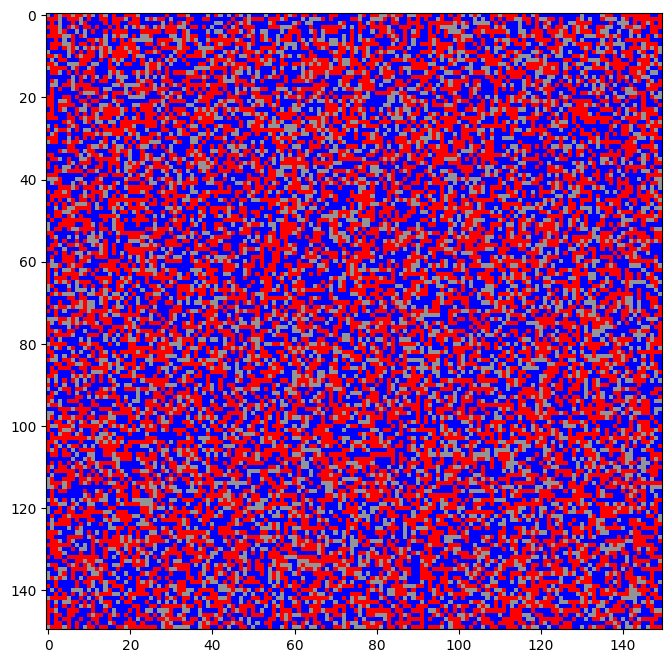

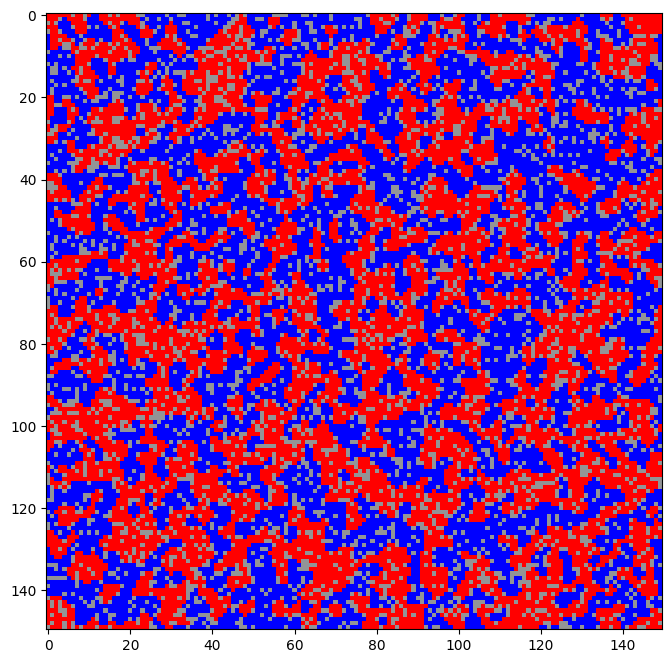

In [19]:
N = 150
red_density = 0.4
blue_density = 0.4
city_type = "open"
tolerance = 5/8
neighbourhood_range = 1

city, vacancy_array, reds, blues = create_city(N, red_density, blue_density, city_type, neighbourhood_range) 

init_city = np.ndarray.copy(city)

city, unhappy_agents, unhappy_map = detect_city_unhappiness(city, city_type, neighbourhood_range, tolerance)

passo = np.infty
for i in range(100000):
    city, unhappy_agents, unhappy_map, vacancy_array = simulation_step(city, city_type, unhappy_agents, unhappy_map, vacancy_array, neighbourhood_range, tolerance)
    if(unhappy_agents[0,0] == 0):
        print("break")
        break
    if(i%passo == 0):
        plot_grid(city)
        time.sleep(0.1)
        display.clear_output(wait=True)
       
plot_grid(init_city)
plot_grid(city)

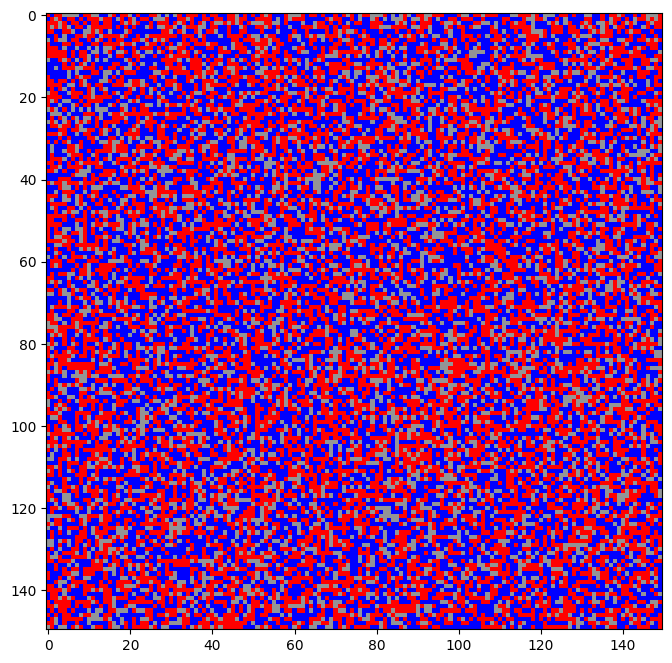

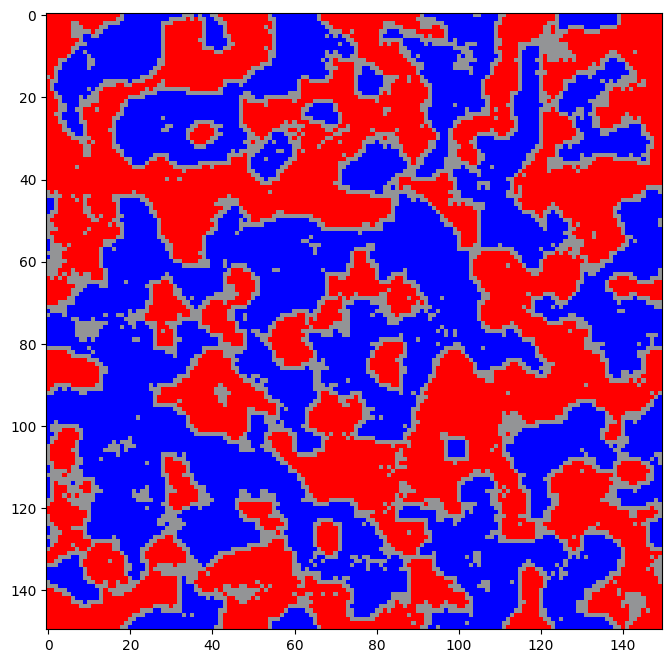

In [16]:
N = 150
red_density = 0.4
blue_density = 0.4
city_type = "open"
neighbourhood_range = 1

city, vacancy_array, reds, blues = create_city(N, red_density, blue_density, city_type, neighbourhood_range) 

init_city = np.ndarray.copy(city)

for i in range(1500):
    evolve(city)
    
plot_grid(init_city)
plot_grid(city)

#### CREATING A GIF

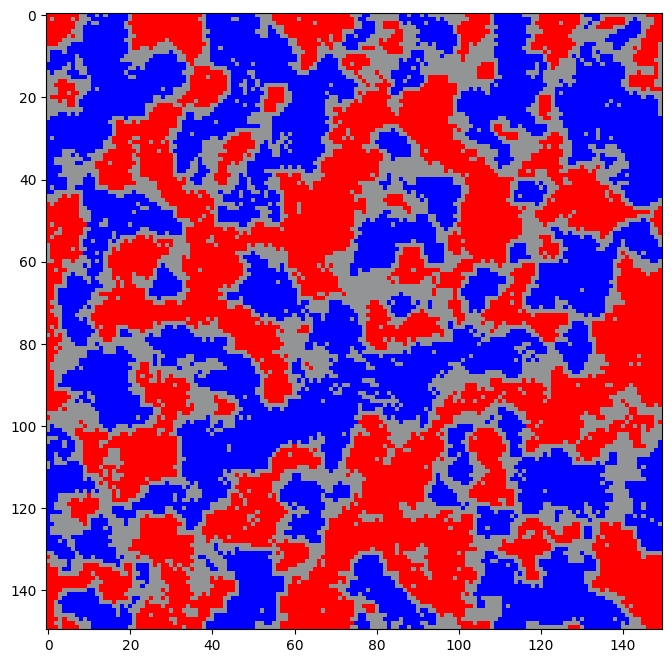

[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0. -1.  0. ... -1.  0.  0.]
 [ 0.  0.  0. ... -1.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0. -1. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


In [ ]:
N = 150
red_density = 0.35
blue_density = 0.35

city, city_type, reds, blues = create_city(N, red_density, blue_density, "open") 

plot_grid(city)

time.sleep(1)
display.clear_output(wait=True)
#city, unhappy_agents = detect_city_unhappiness(city, city_type)

#plot_grid(city)

for i in range(150):
    evolve(city)
    if(i%2 == 0):
        # REMOVE plt.show() FROM THE plot_grid FUNCTION
        plot_grid(city)
        plt.savefig(str(i) + ".png")
        plt.show()
        
        display.clear_output(wait=True)
    
plot_grid(city)
print(city)

#for _ in range(1000):
#    city, unhappy_agents = simulation_step(city, city_type, unhappy_agents)

#plot_grid(city)

In [ ]:
for i in range(0,150,2):
    print(" \'" + str(i) + ".png\',",end='')

 '0.png', '2.png', '4.png', '6.png', '8.png', '10.png', '12.png', '14.png', '16.png', '18.png', '20.png', '22.png', '24.png', '26.png', '28.png', '30.png', '32.png', '34.png', '36.png', '38.png', '40.png', '42.png', '44.png', '46.png', '48.png', '50.png', '52.png', '54.png', '56.png', '58.png', '60.png', '62.png', '64.png', '66.png', '68.png', '70.png', '72.png', '74.png', '76.png', '78.png', '80.png', '82.png', '84.png', '86.png', '88.png', '90.png', '92.png', '94.png', '96.png', '98.png', '100.png', '102.png', '104.png', '106.png', '108.png', '110.png', '112.png', '114.png', '116.png', '118.png', '120.png', '122.png', '124.png', '126.png', '128.png', '130.png', '132.png', '134.png', '136.png', '138.png', '140.png', '142.png', '144.png', '146.png', '148.png',

In [ ]:
import os
import imageio.v2 as imageio

In [ ]:
with imageio.get_writer('evolucao.gif', mode='I') as writer:
    for filename in ['0.png', '2.png', '4.png', '6.png', '8.png', '10.png', '12.png', '14.png', '16.png', '18.png', '20.png', '22.png', '24.png', '26.png', '28.png', '30.png', '32.png', '34.png', '36.png', '38.png', '40.png', '42.png', '44.png', '46.png', '48.png', '50.png', '52.png', '54.png', '56.png', '58.png', '60.png', '62.png', '64.png', '66.png', '68.png', '70.png', '72.png', '74.png', '76.png', '78.png', '80.png', '82.png', '84.png', '86.png', '88.png', '90.png', '92.png', '94.png', '96.png', '98.png', '100.png', '102.png', '104.png', '106.png', '108.png', '110.png', '112.png', '114.png', '116.png', '118.png', '120.png', '122.png', '124.png', '126.png', '128.png', '130.png', '132.png', '134.png', '136.png', '138.png', '140.png', '142.png', '144.png', '146.png', '148.png']:
        image = imageio.imread(filename)
        writer.append_data(image)